![QuantConnect Logo](https://cdn.quantconnect.com/web/i/logo-small.png)
Welcome to The QuantConnect Research Page!

Refer to this page for documentation https://www.quantconnect.com/docs#Introduction-to-Jupyter

Contribute to this template file https://github.com/QuantConnect/Research/tree/master/Notebooks

In [1]:
%matplotlib inline
from clr import AddReference
AddReference("System")
AddReference("QuantConnect.Common")
AddReference("QuantConnect.Jupyter")
AddReference("QuantConnect.Indicators")
from System import *
from QuantConnect import *
from QuantConnect.Data.Market import TradeBar, QuoteBar
from QuantConnect.Jupyter import *
from QuantConnect.Indicators import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
qb = QuantBook()

In [2]:
class PortfolioOptimization:
    """ 
    Description: 
        This class shows how to set up a basic asset allocation problem
        that uses mean-variance portfolio optimization to estimate efficient
        portfolio and plot the efficient frontier and capital market line
    Args:
       log_return(pandas.DataFrame): The log return for assets in portfolio
                                    index: date
                                    columns: symbols
                                    value: log return series                                    
       risk_free_rate(float): The risk free rate 
       num_assets(int): The number of assets in portfolio 
        
    """


    def __init__(self, log_return, risk_free_rate, num_assets):
        self.log_return = log_return
        self.risk_free_rate = risk_free_rate
        self.n = num_assets 

    def annual_port_return(self, weights):
        ''' calculate the annual return of portfolio ''' 
        
        return np.sum(self.log_return.mean() * weights) * 252

    def annual_port_vol(self, weights):
        ''' calculate the annual volatility of portfolio ''' 
        
        return np.sqrt(np.dot(weights.T, np.dot(self.log_return.cov() * 252, weights)))

    def mc_mean_var(self):
        ''' apply monte carlo method to search for the feasible region of return '''
        
        returns = []
        vols = []
        for i in range(5000):
            weights = np.random.rand(self.n)
            weights /= np.sum(weights)
            returns.append(self.annual_port_return(weights))
            vols.append(self.annual_port_vol(weights))
        return returns, vols

    def min_func(self, weights):
        return - self.annual_port_return(weights) / self.annual_port_vol(weights)

    def opt_portfolio(self):
        ''' maximize the sharpe ratio to find the optimal weights ''' 
        
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds = tuple((0, 1) for x in range(self.n))
        opt = minimize(self.min_func,
                       np.array(self.n * [1. / self.n]),
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
        opt_weights = opt['x']
        opt_return = self.annual_port_return(opt_weights)
        opt_volatility = self.annual_port_vol(opt_weights)

        return opt_weights, opt_return, opt_volatility

    def min_var_portfolio(self):
        ''' find the portfolio with minimum volatility '''
        
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds = tuple((0, 1) for x in range(self.n))
        opt = minimize(self.annual_port_vol,
                       np.array(self.n * [1. / self.n]),
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)
        min_vol_weights = opt['x']
        min_vol_return = self.annual_port_return(min_vol_weights)
        min_volatility = self.annual_port_vol(min_vol_weights)
        return min_vol_weights, min_vol_return, min_volatility

    def efficient_frontier(self, mc_returns):
        ''' calculate the efficient frontier ''' 
        
        target_return = np.linspace(min(mc_returns), max(mc_returns) + 0.05, 100)
        target_vol = []
        bnds = tuple((0, 1) for x in range(self.n))
        for i in target_return:
            cons = ({'type': 'eq', 'fun': lambda x: self.annual_port_return(x) - i},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            opt = minimize(self.annual_port_vol,
                           np.array(self.n * [1. / self.n]),
                           method='SLSQP',
                           bounds=bnds,
                           constraints=cons)
            target_vol.append(opt['fun'])
        return target_vol, target_return

    def plot(self):
        mc_returns, mc_vols = self.mc_mean_var()
        target_vol, target_return = self.efficient_frontier(mc_returns)
        opt_weights, opt_return, opt_volatility = self.opt_portfolio()
        min_vol_weights, min_vol_return, min_volatility = self.min_var_portfolio()

        plt.figure(figsize=(15, 8))
        # plot the possible mean-variance portfolios with monte carlo simulation
        excess_return = [i - self.risk_free_rate for i in mc_returns]
        plt.scatter(mc_vols, mc_returns, c=np.array(excess_return) / np.array(mc_vols), cmap=cm.jet, marker='.')
        plt.grid()
        plt.xlabel('standard deviation(annual)')
        plt.ylabel('expected return(annual)')
        plt.colorbar(label='Sharpe ratio')

        # plot the efficient frontier
        plt.scatter(target_vol, target_return, c=np.array(target_return) / np.array(target_vol), marker='.', cmap=cm.jet)

        # mark the optimal portfolio with green star
        plt.scatter(opt_volatility, opt_return, marker='*', s=200, c='g', label = 'optimal portfolio')

        # mark the min volatility portfolio with purple star
        plt.scatter(min_volatility, min_vol_return, marker='*', s=200, c='m', label = 'min volatility portfolio')

        # plot the capital market line with black
        cml_x = np.linspace(0.0, 0.3)
        cml_slope = (opt_return - self.risk_free_rate) / opt_volatility
        plt.plot(cml_x, self.risk_free_rate + cml_slope * cml_x, lw=1.5, c='k', label = 'capital market line')
        plt.legend()

In [3]:
np.random.seed(123)
symbols = ['CCE','AAP','AAPL','GOOG','IBM','AMZN'] 
data = {}
for i in symbols:
    qb.AddEquity(i, Resolution.Daily)
    history = qb.History([i], 500, Resolution.Daily)
    data[i] = history.loc[i]['close'] 
df_price = pd.DataFrame(data,columns=data.keys()) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde8d31d7f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fde85bfd2b0>]], dtype=object)

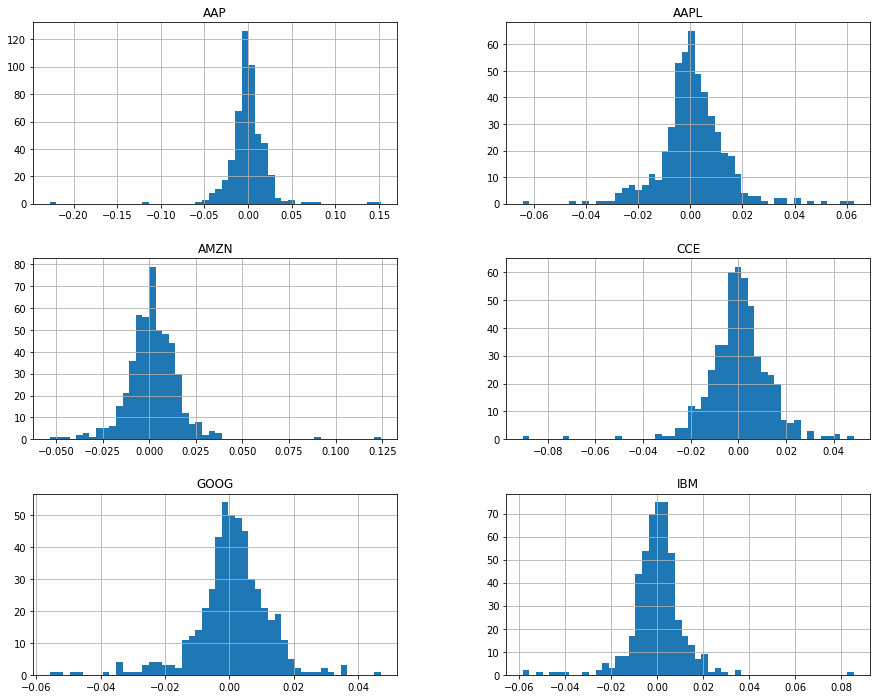

In [4]:
# calculate the log return series for each stock
log_return = np.log(df_price / df_price.shift(1)).dropna()
# plot the histogram of stocks
log_return.hist(bins=50, figsize=(15, 12))

In [5]:
# create the portfolio object 'a' with given symbols
a = PortfolioOptimization(log_return, 0, len(symbols))
opt_portfolio = a.opt_portfolio()
opt_portfolio[0]

array([  0.00000000e+00,   3.01608912e-17,   1.87769608e-01,
         0.00000000e+00,   0.00000000e+00,   8.12230392e-01])

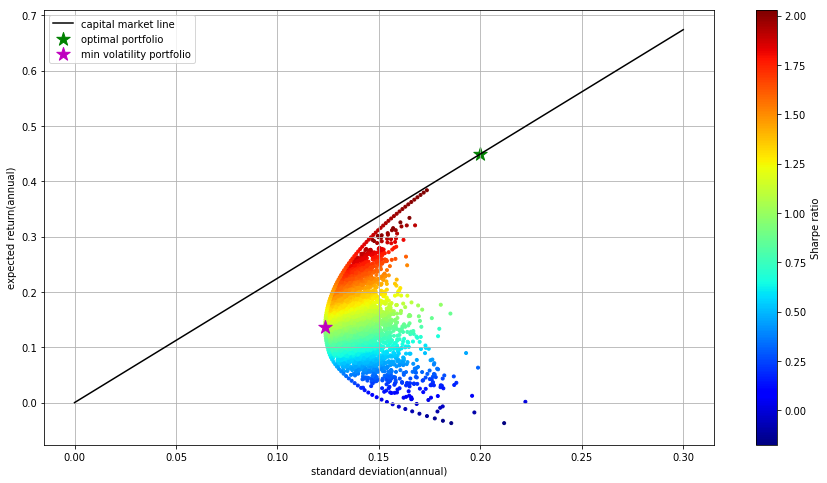

In [6]:
a.plot()

In [7]:
# print out the return, volatility, Sharpe ratio and weights of the optimal portfolio
df = pd.DataFrame({'return':opt_portfolio[1], 'volatility':opt_portfolio[2]},
                  index=['optimal portfolio'])

In [8]:
df

,return,volatility
optimal portfolio,0.44943,0.200018
